# Spectrum simulation with Gammapy

## Introduction

This notebook explains how to use the functions and classes in [gammapy.spectrum](http://docs.gammapy.org/en/latest/spectrum/index.html) in order to simulate and fit spectra.

First, we will simulate and fit a pure power law without any background. Than we will add a power law shaped background component. Finally, we will see how to simulate and fit a user defined model. For all scenarios a toy detector will be simulated. For an example using real CTA IRFs, checkout [this notebook](https://github.com/gammapy/gammapy-extra/blob/master/notebooks/spectrum_simulation_cta.ipynb).

The following clases will be used:

* [gammapy.irf.EffectiveAreaTable](http://docs.gammapy.org/en/latest/api/gammapy.irf.EffectiveAreaTable.html)
* [gammapy.irf.EnergyDispersion](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDispersion)
* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumSimulation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumSimulation.html)
* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.spectrum.models.PowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.PowerLaw.html)
* [gammapy.spectrum.models.SpectralModel](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.SpectralModel.html)

Feedback welcome!

## Setup

Same procedure as in every script ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import numpy as np
import astropy.units as u
from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import PowerLaw, SpectralModel
from gammapy.utils.modeling import Parameter, ParameterList

## Create detector

For the sake of self consistency of this tutorial, we will simulate a simple detector. For a real application you would want to replace this part of the code with loading the IRFs or your detector (TODO: Link to IRFs tutorial)

/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


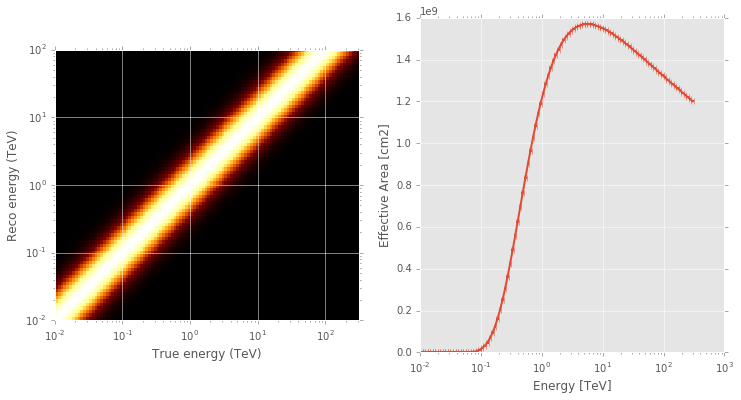

In [3]:
e_true = np.logspace(-2, 2.5, 109) * u.TeV
e_reco = np.logspace(-2,2, 79) * u.TeV

edisp = EnergyDispersion.from_gauss(e_true=e_true, e_reco=e_reco, sigma=0.2)
aeff = EffectiveAreaTable.from_parametrization(energy=e_true)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
edisp.plot_matrix(ax=axes[0])
aeff.plot(ax=axes[1])

## Power law

In this section we will simulate one observation using a power law model.

In [4]:
index = 2.3 * u.Unit('')
amplitude = 1e-12 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

pwl = PowerLaw(index=index, amplitude=amplitude, reference=reference)
print(pwl)

livetime = 2 * u.h

PowerLaw
ParameterList
Parameter(name=u'index', value=2.3, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name=u'amplitude', value=1e-12, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name=u'reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)
Covariance: None


In [5]:
sim = SpectrumSimulation(aeff=aeff,
                         edisp=edisp,
                         source_model=pwl,
                         livetime=livetime)
sim.simulate_obs(seed=2309, obs_id=1)
print(sim.obs)

*** Observation summary report ***
Observation Id: 1
Livetime: 2.000 h
On events: 39
Off events: 0
Alpha: 1.000
Bkg events in On region: 0.00
Excess: 39.00
Excess / Background: inf
Gamma rate: 0.00 1 / min
Bkg rate: 0.00 1 / min
Sigma: nan
energy range: 0.01 TeV - 100.00 TeV


/home/kingj/Software/gammapy/gammapy/data/obs_stats.py:225: RuntimeWarning: divide by zero encountered in divide
  self.background))
/home/kingj/Software/gammapy/gammapy/stats/poisson.py:385: RuntimeWarning: divide by zero encountered in log
  m = n_off * log(n_off * temp)
/home/kingj/Software/gammapy/gammapy/stats/poisson.py:385: RuntimeWarning: invalid value encountered in multiply
  m = n_off * log(n_off * temp)


In [6]:
fit = SpectrumFit(obs_list=sim.obs, model=pwl.copy(), stat='cash')
fit.fit_range = [1, 10] * u.TeV
fit.fit()
fit.est_errors()
print(fit.result[0])


Fit result info 
--------------- 
Model: PowerLaw
ParameterList
Parameter(name=u'index', value=2.3778524259509606+/-0.6556665523662503, unit='', min=0, max=None, frozen=False)
Parameter(name=u'amplitude', value=1.1593958153874414e-12+/-5.17523451497214e-13, unit='', min=0, max=None, frozen=False)
Parameter(name=u'reference', value=1.0, unit='', min=None, max=None, frozen=True)
Covariance: None 

Statistic: 26.816 (cash)
Covariance:
[u'index', u'amplitude']
[[  4.29898628e-01   2.26225796e-13]
 [  2.26225796e-13   2.67830523e-25]]
Fit Range: [ 1.          9.42668455] TeV



## Include background

In this section we will include a background component. Furthermore, we will also simulate more than one observation and fit each one individuallt in order to get average fit results.

In [22]:
bkg_index = 2.5 * u.Unit('')
bkg_amplitude = 1e-12 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

bkg_model = PowerLaw(index=bkg_index, amplitude=bkg_amplitude, reference=reference)
alpha = 0.2

In [28]:
n_obs = 10
seeds = np.arange(n_obs)

sim = SpectrumSimulation(aeff=aeff,
                         edisp=edisp,
                         source_model=pwl,
                         livetime=livetime,
                         background_model=bkg_model,
                         alpha=alpha)

sim.run(seeds)
print(sim.result)
print(sim.result[0])

SpectrumObservationList
Number of observations: 10
*** Observation summary report ***
Observation Id: 0
Livetime: 4.000 h
On events: 139
Off events: 382
Alpha: 0.200
Bkg events in On region: 76.40
Excess: 62.60
Excess / Background: 0.82
Gamma rate: 0.00 1 / min
Bkg rate: 0.00 1 / min
Sigma: 5.74
energy range: 0.01 TeV - 100.00 TeV


Before moving on to the fit let's have a look at the simulated observations

(array([ 1.,  0.,  0.,  1.,  1.,  4.,  0.,  2.,  0.,  1.]),
 array([ 47.6 ,  51.02,  54.44,  57.86,  61.28,  64.7 ,  68.12,  71.54,
         74.96,  78.38,  81.8 ]),
 <a list of 10 Patch objects>)

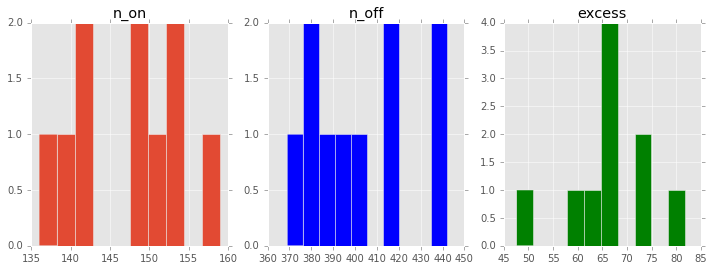

In [24]:
n_on = [obs.total_stats.n_on for obs in sim.result]
n_off = [obs.total_stats.n_off for obs in sim.result]
excess = [obs.total_stats.excess for obs in sim.result]

fix, axes = plt.subplots(1,3, figsize=(12, 4))
axes[0].set_title('n_on')
axes[0].hist(n_on)
axes[1].set_title('n_off')
axes[1].hist(n_off, color='blue')
axes[2].set_title('excess')
axes[2].hist(excess, color='green')

In [25]:
best_fit_index = list()

pwl.parameters['index'].parmax = 10
for obs in sim.result:
    fit = SpectrumFit(obs, pwl.copy(), stat='wstat')
    fit.model.parameters['index'].value = 2
    fit.fit_range = [1, 10] * u.TeV
    fit.fit()
    best_fit_index.append(fit.result[0].model.parameters['index'].value)

[1.5115670164852906, 2.3867445352930492, 2.3795992347042043, 2.364968759034638, 2.8138602960393158, 2.6403545840192026, 2.8019862882529769, 2.1027835592892368, 2.5282476676874501, 1.8971885984107186]


(array([ 1.,  0.,  1.,  0.,  1.,  0.,  3.,  1.,  1.,  2.]),
 array([ 1.51156702,  1.64179634,  1.77202567,  1.902255  ,  2.03248433,
         2.16271366,  2.29294298,  2.42317231,  2.55340164,  2.68363097,
         2.8138603 ]),
 <a list of 10 Patch objects>)

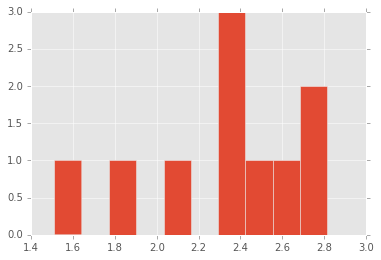

In [26]:
print(best_fit_index)
plt.hist(best_fit_index)

## User defined model

Now we'll see how you can use a custom model for the simulations. To do that you need to subclass SpectralModel. As an example we will use a PowerLaw plus a Gaussian (with fixed width).

In [65]:
class UserModel(SpectralModel):
    def __init__(self, index, amplitude, reference, mean, width):
        self.parameters = ParameterList([
                Parameter('index', index, parmin=0),
                Parameter('amplitude', amplitude, parmin=0),
                Parameter('reference', reference, frozen=True),
                Parameter('mean', mean, parmin=0),
                Parameter('width', width, parmin=0, frozen=True)
            ])
    def evaluate(self, energy, index, amplitude, reference, mean, width):
        pwl = PowerLaw.evaluate(energy=energy, index=index, amplitude=amplitude, reference=reference)
        gauss = amplitude * np.exp(-1 *(energy - mean) ** 2/( 2 * width ** 2))
        return pwl + gauss

In [66]:
index = 2 * u.Unit('')
amplitude = 1e-12 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV
mean = 5 * u.TeV
width = 0.2 * u.TeV

model = UserModel(index=index,
                  amplitude=amplitude,
                  reference=reference,
                  mean=mean,
                  width=width)
print(model)

UserModel
ParameterList
Parameter(name='index', value=2.0, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=1e-12, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)
Parameter(name='mean', value=5.0, unit=Unit("TeV"), min=0, max=None, frozen=False)
Parameter(name='width', value=0.2, unit=Unit("TeV"), min=0, max=None, frozen=True)
Covariance: None


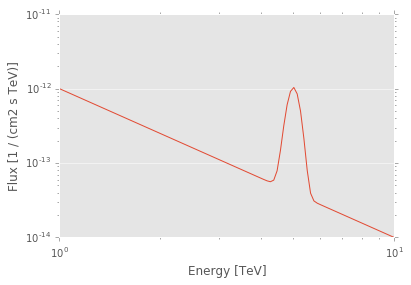

In [67]:
energy_range = [1, 10] * u.TeV

fig, ax = plt.subplots(1)
model.plot(ax=ax, energy_range=energy_range)

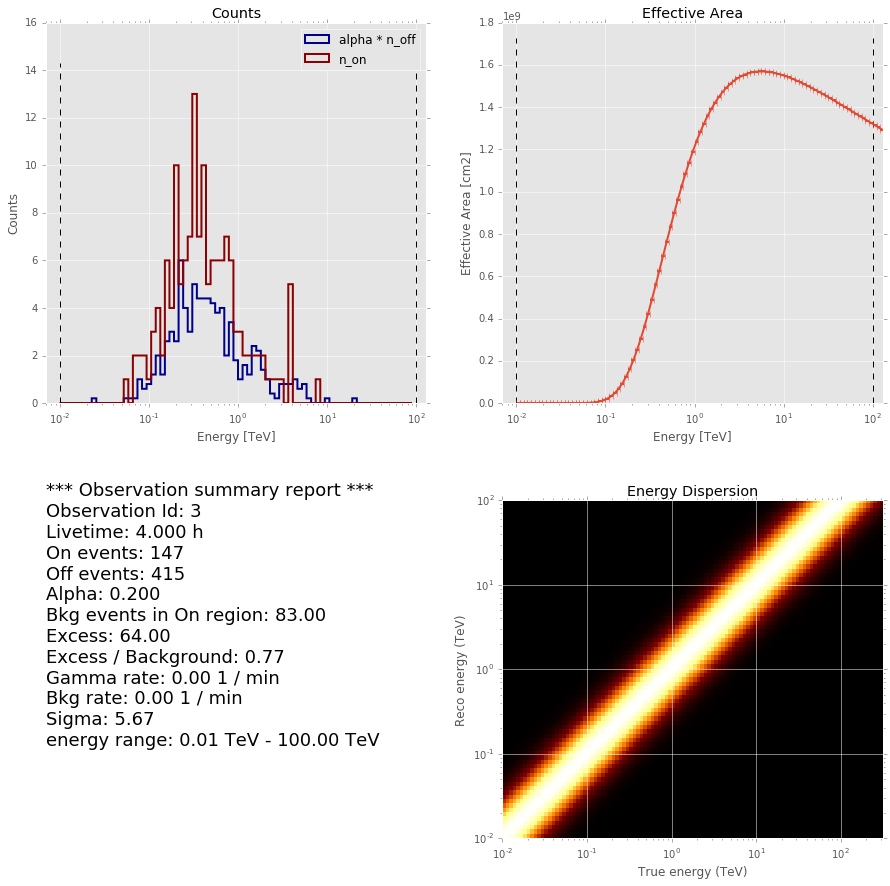

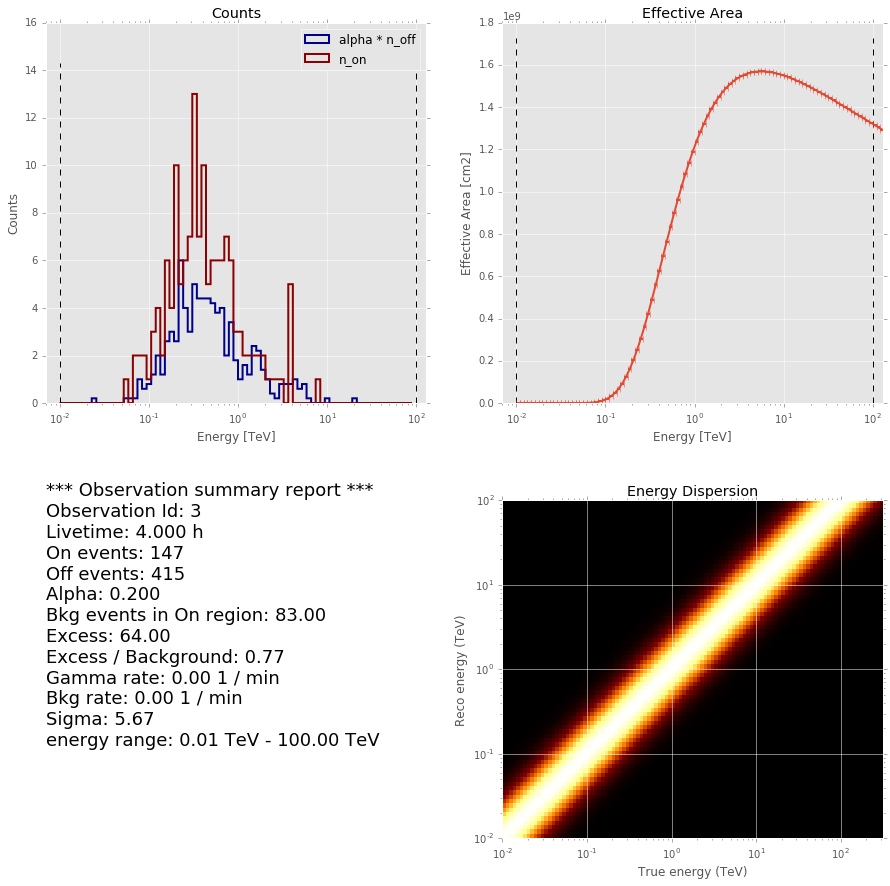

In [72]:
sim = SpectrumSimulation(aeff=aeff,
                         edisp=edisp,
                         source_model=pwl,
                         livetime=livetime,
                         background_model=bkg_model,
                         alpha=alpha)

sim.simulate_obs(seed=41, obs_id=3)
sim.obs.peek()

## Exercises

* Fit a pure power law and the user define model to the observation you just simulated.
* Vary the observation lifetime and see when you can distinguish the two models (Hint: You get the final likelihood of a fit from fit.result[0].statval).

## What's next

In this tutorial we learnd how to simulate and fit data using a toy detector. Go to [gammapy.spectrum](http://docs.gammapy.org/en/latest/spectrum/index.html) to see what else you can do with gammapy.